In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = Path.cwd().parents[0] / 'output/vote_result.xlsx'
df = pd.read_excel(path)

In [3]:
def preprocess_df(df):
    return (df
        .drop(columns='nama')
    )

df_clean = preprocess_df(df)

NUM_COLS = ['vote', 'no_urut', 'partai_vote']
CAT_COLS = ['dapil_no', 'dapil_nama', 'partai']
TARGET = ['terpilih']

assert sorted(NUM_COLS + CAT_COLS + TARGET) == sorted(df_clean.columns)

x = df_clean[NUM_COLS + CAT_COLS]
y = df_clean[TARGET]

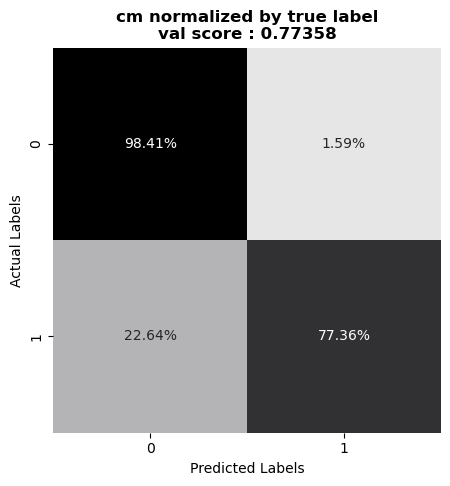

In [17]:
# preprocessing pipeline
numerical_pipe = Pipeline([
    ('scale', StandardScaler())
])
categorical_pipe = Pipeline([
    ('encode', OneHotEncoder(sparse_output=False)), 
    ('scale', StandardScaler())
])
pipe = ColumnTransformer([
    ("numerical", numerical_pipe, NUM_COLS),
    ("categorical", categorical_pipe, CAT_COLS)
])

# prediction pipeline
prediction= Pipeline([
    ('model', XGBClassifier())
])

# full pipeline
pipeline= Pipeline([
    ('preprocessing', pipe),
    ('prediction', prediction)
])

# fold
fold= StratifiedKFold(
    n_splits= 5, 
    shuffle= True, 
    random_state= 8
)

# training
y_pred= cross_val_predict(
    estimator = pipeline, 
    cv= fold, 
    X= x, 
    y= y, 
    n_jobs= -1, 
    verbose= 0
)

val_score = f1_score(y, y_pred)
# print(f'val score : {val_score}')

cm = confusion_matrix(y, y_pred, normalize='true')
plt.figure(figsize=(5, 5))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, cmap=cmap, cbar=False, fmt='.2%')

plt.title(f'cm normalized by true label\nval score : {val_score:.5f}', fontweight='bold')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

plt.show()